# 2.6 Covariance Estimation

## Covariance

- 공분산이란 둘 이상의 변수가 연관성을 가지며 분포하는 모양을 전체적으로 나타낸 분산
- Cov(x, y) > 0 : x가 증가할 때 y도 증가
- Cov(x, y) < 0 : x가 증가할 때 y는 감소
- Cov(x, y) == 0 : 보통 independent지만 항상 independent하지는 않다.

## Correlation

- 공분산 값이 항상 일정하지 않아 이를 표준화하기 위하여 표준편차로 나누면 [-1, 1]의 값의 범위를 가진다.
- 이를 상관계수 Corr(x, y)라고 한다.

## Covariance Matrix(공분산 행렬)

- X1의 분산은 x들이 평균을 중심으로 얼마나 흩어져 있는지 나타냄
- X1과 X2의 공분산(Cov|X1, X2|)는 X1, X2의 흩어진 정도가 얼마나 서로 상관관계를 가지고 흩어졌는지 나타낸다.

## 1. Empirical Covariance : 경험적 공분산

- 데이터 집합의 공분산 행렬은 관측치의 수가 형상의 수에 비해 크면 기본 최대 우도 추정기가 거의 근접함을 나타낸다.
- 표본의 경험적 공분산 행렬은 패키지의 경험적 공분산 함수를 사용하거나 각 개체를 데이터 샘플에 적합시켜 계산할 수 있다. 
- 예를 들어, 가정_중심=False이면 검정 집합은 훈련 집합과 같은 평균 벡터를 갖는 것으로 가정한다. 그렇지 않은 경우 둘 다 사용자가 중심이 되어야 하며, 가정_중심=True를 사용해야 합니다.

## 2. Shrunk Covariance

### Basic Shrinkage

- 공분산 행렬의 점근적 편향 추정기임에도, 최대 우도 추정기는 좋은 추정기가 아니다. 때때로 경험적 공분산 행렬이 수치적 이유로 뒤집힐 수 없는 경우가 발생하는데 이러한 문제를 피하기 위하여 경험적 공분산 행렬에 변환 수축이 도입되었다. 
- 수학적으로 이 축소는 경험적 공분산 행렬의 가장 작은 고유값과 가장 큰 고유값 사이의 비율을 줄이는 것으로 구성된다.

### 축소 공분산 추정 : LedoitWolf vs OAS와 최대 우도

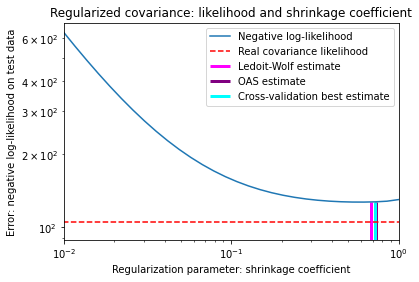

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import (
    LedoitWolf,
    OAS,
    ShrunkCovariance,
    log_likelihood,
    empirical_covariance,
)
from sklearn.model_selection import GridSearchCV

# 샘플 데이터 생성
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# 색 샘플
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# 테스트 데이터 우도 추정
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [
    -ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test) for s in shrinkages
]
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# 매개 변수 세팅에 대한 다른 접근 비교하기

# 적절한 축소 변환을 위한 GridSearch
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# plot 결과 출력
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel("Regularization parameter: shrinkage coefficient")
plt.ylabel("Error: negative log-likelihood on test data")
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], "--r", label="Real covariance likelihood")

lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10.0 * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]

# LW 우도
plt.vlines(
    lw.shrinkage_,
    ymin,
    -loglik_lw,
    color="magenta",
    linewidth=3,
    label="Ledoit-Wolf estimate",
)
# OAS 우도
plt.vlines(
    oa.shrinkage_, ymin, -loglik_oa, color="purple", linewidth=3, label="OAS estimate"
)

# 최고의 CV 측정기
plt.vlines(
    cv.best_estimator_.shrinkage,
    ymin,
    -cv.best_estimator_.score(X_test),
    color="cyan",
    linewidth=3,
    label="Cross-validation best estimate",
)

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()
plt.show()

## 3. Sparse Inverse Covariance

- 공분산 행렬의 역행렬(정밀 행렬)은 편상관 행렬에 비례하는ㄴ데 이는 부분 독립 관계를 제공해준다. 즉, 두 형상이 다른 형상에 대해 조건부로 독립적이면 정밀도 행렬의 해당 계수는 0이 된다. 
- 이 것이 Sparse Inverse Covariance를 추정하는 것이 의미가 있는 이유다.
- n_sample이 n_feature가 더 작은 작은 표본 상황에서 Sparse Inverse Covariance의 추정기는 축소 변환보다 더 잘 작동을 한다. 

# 2.8 Density Estimation

- 밀도 추정은 비지도 학습, 특징 가공 및 데이터 모델링 사이의 경계에 존재한다.
- GaussMixture과 같은 혼합물 모델과 커널 밀도(Kernel Density) 추정지와 같은 인접 기반 접근법이 존재

## 1. Histograms 히스토그램

- 히스토그램은 데이터의 포인트 수가 집계되는 간단한 시각화 요소지만 큰 문제는 묶는 선택이 최종 시각화에 불균형적인 영향을 준다. 아래의 그림에 오른쪽 상단을 보면 빈이 오른쪽으로 이동된 동일한 데이터에 대한 히스토그램을 보여주고 이에 따라 해석이 달라진다.

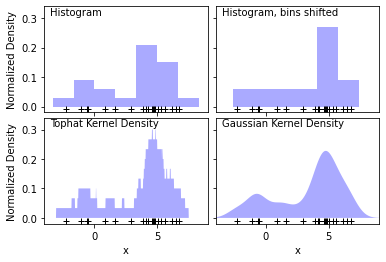

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

if parse_version(matplotlib.__version__) >= parse_version("2.1"):
    density_param = {"density": True}
else:
    density_param = {"normed": True}

np.random.seed(1)
N = 20
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

## 2. Kernel Density Estimation

- 커널 밀도 추정은 Ball Tree나 KD Tree를 효율적인 쿼리로서 사용한다. ㅑ